**# Data Mining: Reglas de asociacion usando Python con Datasets Grandes**

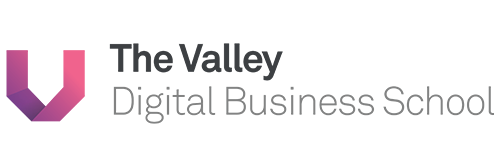

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

### Explicacion del Generador tipo Yield (Necesario para realizar la practica)

un generador es un tipo especial de función que devuelve una secuencia iterable de elementos. Sin embargo, a diferencia de las funciones regulares que devuelven todos los valores de una vez (por ejemplo, todos los elementos de una lista), un generador <i>yields</i> un valor a la vez. Para obtener el siguiente valor en el conjunto, debemos pedirlo explícitamente llamando al método "next" incorporado en el generador, o implícitamente a través de un bucle for. Esta es una gran propiedad de los generadores porque significa que no tenemos que almacenar todos los valores en memoria a la vez. Podemos cargar y procesar un valor a la vez, descartarlo cuando hayamos terminado y pasar al siguiente valor. Esta característica hace que los generadores sean perfectos para crear pares de elementos y contar su frecuencia de co-ocurrencia. Aquí hay un ejemplo concreto de lo que estamos tratando de lograr::  

1. Obtener todos los posibles pares de elementos para un pedido dado
por ejemplo:
       
       Transacción 1:  manzana, huevo, leche  -->  Pares de items: {manzana, huevo}, {manzana, leche}, {huevo, leche}
       Transacción 2:  huevo, leche  -->  Pares de items: {huevo, leche}
            
2. Contar el número de veces que aparece cada par de elementos
por ejemplo:
       {manzana, huevo}: 1
       {manzana, leche}: 1
       {huevo, leche}: 2

Aqui está la implementacion del generador que implementa las dos acciones mencionadas:

In [ ]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Datos de muestra
orders = np.array([[1,'manzana'], [1,'huevo'], [1,'leche'], [2,'huevo'], [2,'leche']], dtype=object)

# Generador que devuelve pares de elementos, uno a la vez
def get_item_pairs(order_item):

    # Para cada pedido, generar una lista de elementos en ese pedido
    for order_id, order_object in groupby(orders, lambda x: x[0]):
        item_list = [item[1] for item in order_object]

        # Para cada lista de elementos, generar pares de elementos, uno a la vez
        for item_pair in combinations(item_list, 2):
            yield item_pair


# Counter: itera a través de los pares de elementos devueltos por nuestro generador y lleva un registro de su ocurrencia
print(Counter(get_item_pairs(orders)))



Counter({('huevo', 'leche'): 2, ('manzana', 'huevo'): 1, ('manzana', 'leche'): 1})


La función get_item_pairs() genera una lista de elementos para cada pedido y produce pares de elementos para ese pedido, uno a la vez. El primer par de elementos se pasa a Counter, que lleva un registro del número de veces que aparece un par de elementos. Se toma el siguiente par de elementos y, de nuevo, se pasa a Counter. Este proceso continúa hasta que no quedan más pares de elementos. Con este enfoque, no usamos mucha memoria ya que los pares de elementos se descartan después de que se actualiza el recuento.

### Algoritmo Apriori
Apriori es un algoritmo utilizado para identificar conjuntos frecuentes de elementos (en nuestro caso, pares de elementos). Lo hace utilizando un enfoque "bottom-up", identificando primero los elementos individuales que satisfacen un umbral mínimo de ocurrencia. Luego, extiende el conjunto de elementos, agregando un elemento a la vez y verificando si el conjunto de elementos resultante aún satisface el umbral especificado. El algoritmo se detiene cuando no hay más elementos para agregar que cumplan con el requisito mínimo de ocurrencia. Aquí hay un ejemplo de Apriori en acción, suponiendo un umbral mínimo de ocurrencia de 3:


    order 1: manzana, huevo, leche
    order 2: zanahoria, leche
    order 3: manzana, huevo, zanahoria
    order 4: manzana, huevo
    order 5: manzana, zanahoria

    
    Primera Iteración: Contar el número de veces que aparece cada elemento
    conjunto de elementos conteo de ocurrencias
    {manzana} 4
    {huevo} 3
    {leche} 2
    {zanahoria} 2

    {leche} y {zanahoria} se eliminan porque no cumplen el umbral mínimo de ocurrencia.

    Segunda Iteración: Construir conjuntos de elementos de tamaño 2 utilizando los elementos restantes de la Iteración 1 (es decir, manzana, huevo)
    conjunto de elementos conteo de ocurrencias
    {manzana, huevo} 3

    Solo queda {manzana, huevo} y el algoritmo se detiene ya que no hay más elementos para agregar.
   
   
Si tuviéramos más pedidos y elementos, podríamos continuar iterando, construyendo conjuntos de elementos que consisten en más de 2 elementos. Para el problema que estamos tratando de resolver (es decir, encontrar relaciones entre pares de elementos), es suficiente implementar apriori para llegar a conjuntos de elementos de tamaño 2.

### Input Dataset
Instacart, un supermercado en línea, ha proporcionado de forma altruista algunos de sus datasets accesibles al público. Usaremos para la practica del algoritmo apriori los datasets: **pedidos y productos** 🎯

In [ ]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [ ]:
# Funcion que nos permite calcular el peso en MB de un objeto
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

### Parte 1: Preparación de los Datos

#### A. Cargamos los datos de transacciones de productos

In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/Clases The Valley/Asignaturas/Outliers y residuos/Modelos_Asociacion_Valley/data/order_products__prior.csv')
orders = orders[:10000000] ## Vamos a limitar el dataframe a 10.000.000 de transacciones para que el calculo no exceda demasiado en tiempo de computación
print('pedidos -- columnas: {0};  Peso (en MB): {1}'.format(orders.shape, size(orders)))
display(orders.head())

pedidos -- columnas: (10000000, 4);  Peso (en MB): 320.00 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


#### B. Convertir los datos de transacciones al formato esperado por la función de reglas de asociación.

In [ ]:
# Convertimos el dataframe de pandas a un pd.Series con el order id como indice y el id del producto como valor
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

#### C. Mostramos las estadisticas basicas sobre el dataset

In [ ]:
print('numero de pedidos: {0}; tamaño: {1}; transacciones_unicas: {2}; productos_unicos: {3}'
.format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

numero de pedidos: (10000000,); tamaño: 160.00 MB; transacciones_unicas: 991714; productos_unicos: 48520


### Parte 2: Crear las funciones para calcular las reglas de asociación

#### A. Creamos las funciones auxiliares que usará la función principal de reglas de asociación.

In [ ]:
# Devuelve la frecuencia de cada elemento y pares de elementos
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")


# Devuelve el número de pedidos únicos
def order_count(order_item):
    return len(set(order_item.index))


# Devuelve un generador que devuelve pares de elementos, uno a la vez
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]

        for item_pair in combinations(item_list, 2):
            yield item_pair


# Devuelve frecuencia y soporte asociados con el elemento
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Devuelve nombre asociado con el elemento
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB',
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]

#### B. Creamos la funcion principial que calcula las reglas de asociación

La función **"association_rules"** recibe un dataframe **"order_item"** y un umbral **"min_support"** como entrada. Realiza los siguientes pasos:

    1.Calcula la frecuencia y el soporte de cada artículo.
    2.Filtra los elementos que tienen un soporte inferior al umbral "min_support".
    3.Filtra las órdenes que tienen menos de dos elementos.
    4.Calcula la frecuencia y el soporte de los elementos restantes.
    5.Crea un generador de pares de elementos.
    6.Calcula la frecuencia y el soporte de cada par de elementos.
    7.Filtra los pares de elementos que tienen un soporte inferior al umbral "min_support".
    8.Calcula las estadísticas de asociación de cada par de elementos (confianza y lift).
    9.Devuelve una tabla de reglas de asociación ordenada por lift de manera descendente.

In [ ]:

def association_rules(order_item, min_support):

    print("Comenzando con order_item: {:22d}".format(len(order_item)))


    # Calcular frecuencia y soporte de los elementos
    item_stats = freq(order_item).to_frame("freq")
    item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100


    # Filtramos los elementos que no alcanzan el soporte mínimo
    qualifying_items = item_stats[item_stats['support'] >= min_support].index
    order_item = order_item[order_item.isin(qualifying_items)]

    print("Elementos con soporte >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("order_item restante: {:21d}".format(len(order_item)))


    # Filtramos las órdenes con menos de 2 elementos
    order_size = freq(order_item.index)
    qualifying_orders  = order_size[order_size >= 2].index
    order_item = order_item[order_item.index.isin(qualifying_orders)]

    print("Órdenes restantes con 2 o más elementos: {:11d}".format(len(qualifying_orders)))
    print("order_item restante: {:21d}".format(len(order_item)))


    # Recalculamos la frecuencia y soporte de los elementos
    item_stats = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Generamos pares de elementos
    item_pair_gen = get_item_pairs(order_item)


    # Calculamos frecuencia y soporte de los pares de elementos
    item_pairs = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Pares de elementos: {:31d}".format(len(item_pairs)))


    # Filtramos pares de elementos que no alcanzan el soporte mínimo
    item_pairs = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Pares de elementos con soporte >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Finalmente, creamos la tabla de reglas de asociación y calculamos las métricas relevantes
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)

    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift'] = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])


    # La función debe devolver las reglas de asociación ordenadas por  la columna lift de forma descendente
    return item_pairs.sort_values('lift', ascending=False)

### Parte 3:  Calculo de las Reglas de Asociación

In [ ]:
%%time
# Ejecutamos el calculo de reglas de asociación
rules = association_rules(orders, 0.01) # ponemos un soporte minimo bajo del 1% dado la gran cantidad de transacciones que tiene el dataset

Comenzando con order_item:               10000000
Elementos con soporte >= 0.01:           10924
order_item restante:               9207067
Órdenes restantes con 2 o más elementos:      929288
order_item restante:               9151032
Pares de elementos:                        17000735
Pares de elementos con soporte >= 0.01:      49286

CPU times: user 4min, sys: 7.89 s, total: 4min 8s
Wall time: 4min 10s


In [ ]:
rules

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
42066,29126,36361,107,0.011514,378,0.040676,277,0.029808,0.283069,0.386282,9.496477
21608,1443,15707,94,0.010115,680,0.073174,214,0.023028,0.138235,0.439252,6.002822
10296,28613,45636,115,0.012375,511,0.054988,355,0.038201,0.225049,0.323944,5.891134
30615,7076,17766,101,0.010869,603,0.064888,265,0.028516,0.167496,0.381132,5.873656
38238,12820,11212,110,0.011837,447,0.048101,400,0.043044,0.246085,0.275000,5.717096
...,...,...,...,...,...,...,...,...,...,...,...
38841,21137,16797,194,0.020876,81579,8.778656,43569,4.688428,0.002378,0.004453,0.000507
7175,47209,47766,137,0.014742,65632,7.062611,54094,5.821016,0.002087,0.002533,0.000359
22508,47766,47209,134,0.014420,54094,5.821016,65632,7.062611,0.002477,0.002042,0.000351
22077,24852,13176,195,0.020984,145337,15.639608,116277,12.512483,0.001342,0.001677,0.000107


In [ ]:
# Reemplazamos el ID del producto por su nombre real y printeamos el dataframe con las reglas de asociación ya calculadas
item_name = pd.read_csv('/content/drive/MyDrive/Clases The Valley/Asignaturas/Outliers y residuos/Modelos_Asociacion_Valley/data/products.csv')
item_name = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,107,0.011514,378,0.040676,277,0.029808,0.283069,0.386282,9.496477
1,Strawberry and Banana Fruit Puree,"Peter Rabbit Organics Mango, Banana and Orange...",94,0.010115,680,0.073174,214,0.023028,0.138235,0.439252,6.002822
2,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,115,0.012375,511,0.054988,355,0.038201,0.225049,0.323944,5.891134
3,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,101,0.010869,603,0.064888,265,0.028516,0.167496,0.381132,5.873656
5,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,110,0.011837,447,0.048101,400,0.043044,0.246085,0.275000,5.717096
...,...,...,...,...,...,...,...,...,...,...,...
10678,Organic Strawberries,Strawberries,194,0.020876,81579,8.778656,43569,4.688428,0.002378,0.004453,0.000507
6949,Organic Hass Avocado,Organic Avocado,137,0.014742,65632,7.062611,54094,5.821016,0.002087,0.002533,0.000359
4360,Organic Avocado,Organic Hass Avocado,134,0.014420,54094,5.821016,65632,7.062611,0.002477,0.002042,0.000351
2600,Banana,Bag of Organic Bananas,195,0.020984,145337,15.639608,116277,12.512483,0.001342,0.001677,0.000107


### Parte 4:  Conclusión

Del resultado anterior, vemos que las principales asociaciones no son sorprendentes, con producto lácteo de un sabor determinado que se compra con otro sabor (por ejemplo: Strawberry Chia Cottage Cheese with Blueberry Acai Cottage Cheese, Chicken Cat Food with Turkey Cat Food, etc). Como hemos mencionado en las diapositivas de teoria, una aplicación común de la minería de reglas de asociación es la aplicación en los sistemas de recomendación.

Una vez que se han identificado pares de productos que tienen una relación positiva, se pueden hacer recomendaciones a los clientes para aumentar las ventas. Y con suerte, también presentar a los clientes productos que nunca hubieran probado antes o incluso imaginado que existían.